In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import csv

import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

from pitch_tracker.utils import files, dataset
from pitch_tracker.utils.constants import SAMPLE_RATE, PATCH_SIZE, RANDOM_STATE

import medleydb


In [6]:
stft_hop_size = 512
analysis_frame_size = 5
n_mels = 88*2
onset_frame_time = stft_hop_size*analysis_frame_size/SAMPLE_RATE
pick_frame_time = PATCH_SIZE * onset_frame_time

DATASET_DIR = f'../content/pickled_database/{stft_hop_size}_{analysis_frame_size}_{n_mels}/'
DATA_SPLIT_PATH = dataset.DATA_SPLIT_PATH


In [7]:
train_df, validation_df, test_df = dataset.split_dataset_df('thesis', pickled_data_dir=DATASET_DIR)

Missing tracks: 0 []
Missing tracks: 0 []
train_set: 64
validation_set: 17
test_set: 27


In [8]:
train_df.head(5)

,track_id,artist,predominant_instrument,melody2_instruments,genre,duration,has_bleed,pickled_path
28,MusicDelta_Beatles,MusicDelta,male singer,"[male singer, female singer]",Singer/Songwriter,36.373515,False,../content/pickled_database/512_5_176/MusicDel...
10,FacesOnFilm_WaitingForGa,FacesOnFilm,male singer,"[male singer, vocalists]",Singer/Songwriter,257.632313,False,../content/pickled_database/512_5_176/FacesOnF...
5,CroqueMadame_Oil,CroqueMadame,clean electric guitar,"[clean electric guitar, piano]",Jazz,451.345011,True,../content/pickled_database/512_5_176/CroqueMa...
13,HeladoNegro_MitadDelMundo,HeladoNegro,male singer,[male singer],Pop,181.850340,False,../content/pickled_database/512_5_176/HeladoNe...
1,AlexanderRoss_GoodbyeBolero,AlexanderRoss,male singer,"[harmonica, male singer, brass section, clean ...",Singer/Songwriter,418.816757,False,../content/pickled_database/512_5_176/Alexande...


# Dataset distribution

## Genres

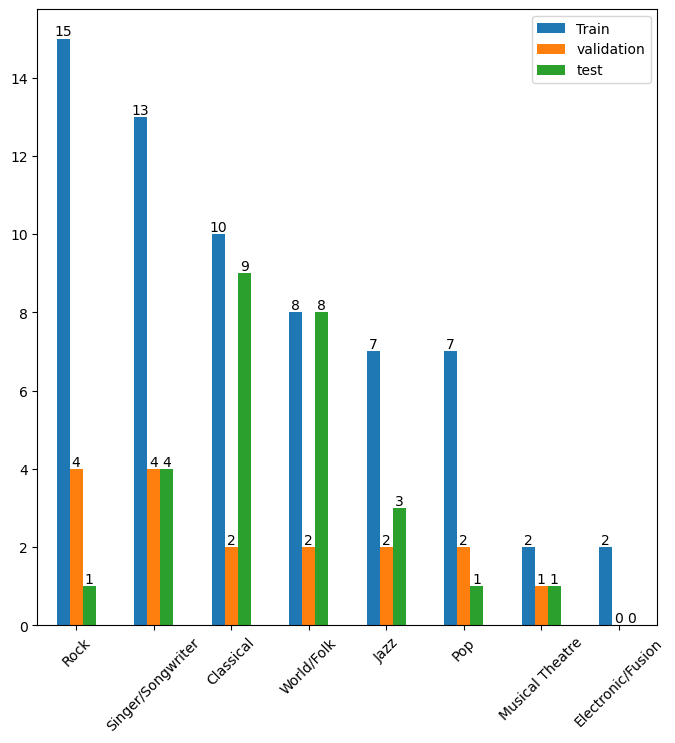

In [9]:
def plot_bars(dfs, figsize=(8, 8)):
    df = pd.concat(dfs, axis=1)
    fig, ax = plt.subplots(figsize=figsize)
    df.plot.bar(rot=45, ax=ax)
    for i in ax.containers:
        ax.bar_label(i)
    plt.show()

series = []
s = train_df['genre'].value_counts()
s.name = "Train"
series.append(s)
s = validation_df['genre'].value_counts()
s.name = "validation"
series.append(s)
s = test_df['genre'].value_counts()
s.name = "test"
series.append(s)

plot_bars(series) 

## Duration

In [10]:
## This commented code will calculate the number of pick_frames using duration 
# train_samples = ((train_df['duration'] / pick_frame_time)+0.5).astype(int).sum()
# validation_samples =((validation_df['duration'] / pick_frame_time)+0.5).astype(int).sum()
# test_samples =((test_df['duration'] / pick_frame_time)+0.5).astype(int).sum()

train_samples = sum([len(files.list_all_file_paths_in_dir(dir_path)) for dir_path in train_df['pickled_path']])
validation_samples = sum([len(files.list_all_file_paths_in_dir(dir_path)) for dir_path in validation_df['pickled_path']])
test_samples = sum([len(files.list_all_file_paths_in_dir(dir_path)) for dir_path in test_df['pickled_path']])

In [11]:
total_samples = train_samples+validation_samples+test_samples
print('Number of frame')
print(f'train: {train_samples}')
print(f'validation: {validation_samples}')
print(f'test: {test_samples}')
print(f'ratio: {train_samples/total_samples:.2f}/{validation_samples/total_samples:.2f}/{test_samples/total_samples:.2f}')

Number of frame
train: 1780
validation: 434
test: 945
ratio: 0.56/0.14/0.30


# Dataset & dataloader

In [12]:
train_set = train_df['pickled_path']
validation_set = validation_df['pickled_path']
test_set = test_df['pickled_path']

In [21]:
train_dataset = dataset.AudioDataset(train_set)
validation_dataset = dataset.AudioDataset(validation_set)
test_dataset = dataset.AudioDataset(test_set)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_set, batch_size=8, shuffle=True)

In [14]:
feature, label = next(iter(train_dataloader))

In [35]:
print(feature.shape, label[2].shape, label[2].type())

torch.Size([8, 1, 1050, 176]) torch.Size([8, 210, 89]) torch.FloatTensor


In [16]:
total_set = pd.concat([train_set, validation_set, test_set])
total_dataset = dataset.AudioDataset(total_set)

In [17]:
def count_labels(dataset, as_ratio:bool=False):
    classes_n_samples = torch.zeros(89, dtype=int)
    for x,(y1, y2, y3) in dataset:
        classes_n_samples += y3.sum(axis=0,dtype=int)
        
    # classes_n_samples
    if as_ratio:
        total_classes_samples = 210*len(dataset)
        classes_ratio = classes_n_samples/total_classes_samples
        return classes_ratio
    return classes_n_samples

In [18]:
from matplotlib import pyplot as plt

In [30]:
classes_ratio = count_labels(total_dataset, as_ratio=True)
train_classes_ratio = count_labels(train_dataset, as_ratio=False)
validation_classes_ratio = count_labels(validation_dataset, as_ratio=True)
test_classes_ratio = count_labels(test_dataset, as_ratio=True)

series = [
    pd.Series(classes_ratio.numpy()),
    pd.Series(train_classes_ratio.numpy()),
    pd.Series(validation_classes_ratio.numpy()),
    pd.Series(test_classes_ratio.numpy()),
          ]

In [33]:
train_classes_ratio

tensor([130006,      0,      0,      0,      0,      0,      0,      0,      0,
             2,      0,      2,      6,    116,    152,   1028,   1358,     82,
           333,    366,    570,   1652,    671,   1867,   1257,   1282,   1734,
          1451,   2427,   1778,   3297,   4774,   3121,   3719,   6356,  10561,
          6629,   8566,   7294,  13550,  10921,   9746,  12463,   9343,   9269,
          6984,   7413,  12393,   5880,  10275,   6299,   6798,   6667,   3993,
          7962,   4139,   4137,   2505,   1863,   4679,   1019,   2684,   1071,
          2744,   1066,    453,   1853,    230,   1380,    147,    307,    441,
           119,    360,     16,    118,     22,      6,     18,      8,      2,
             0,      0,      0,      0,      0,      0,      0,      0])

[]

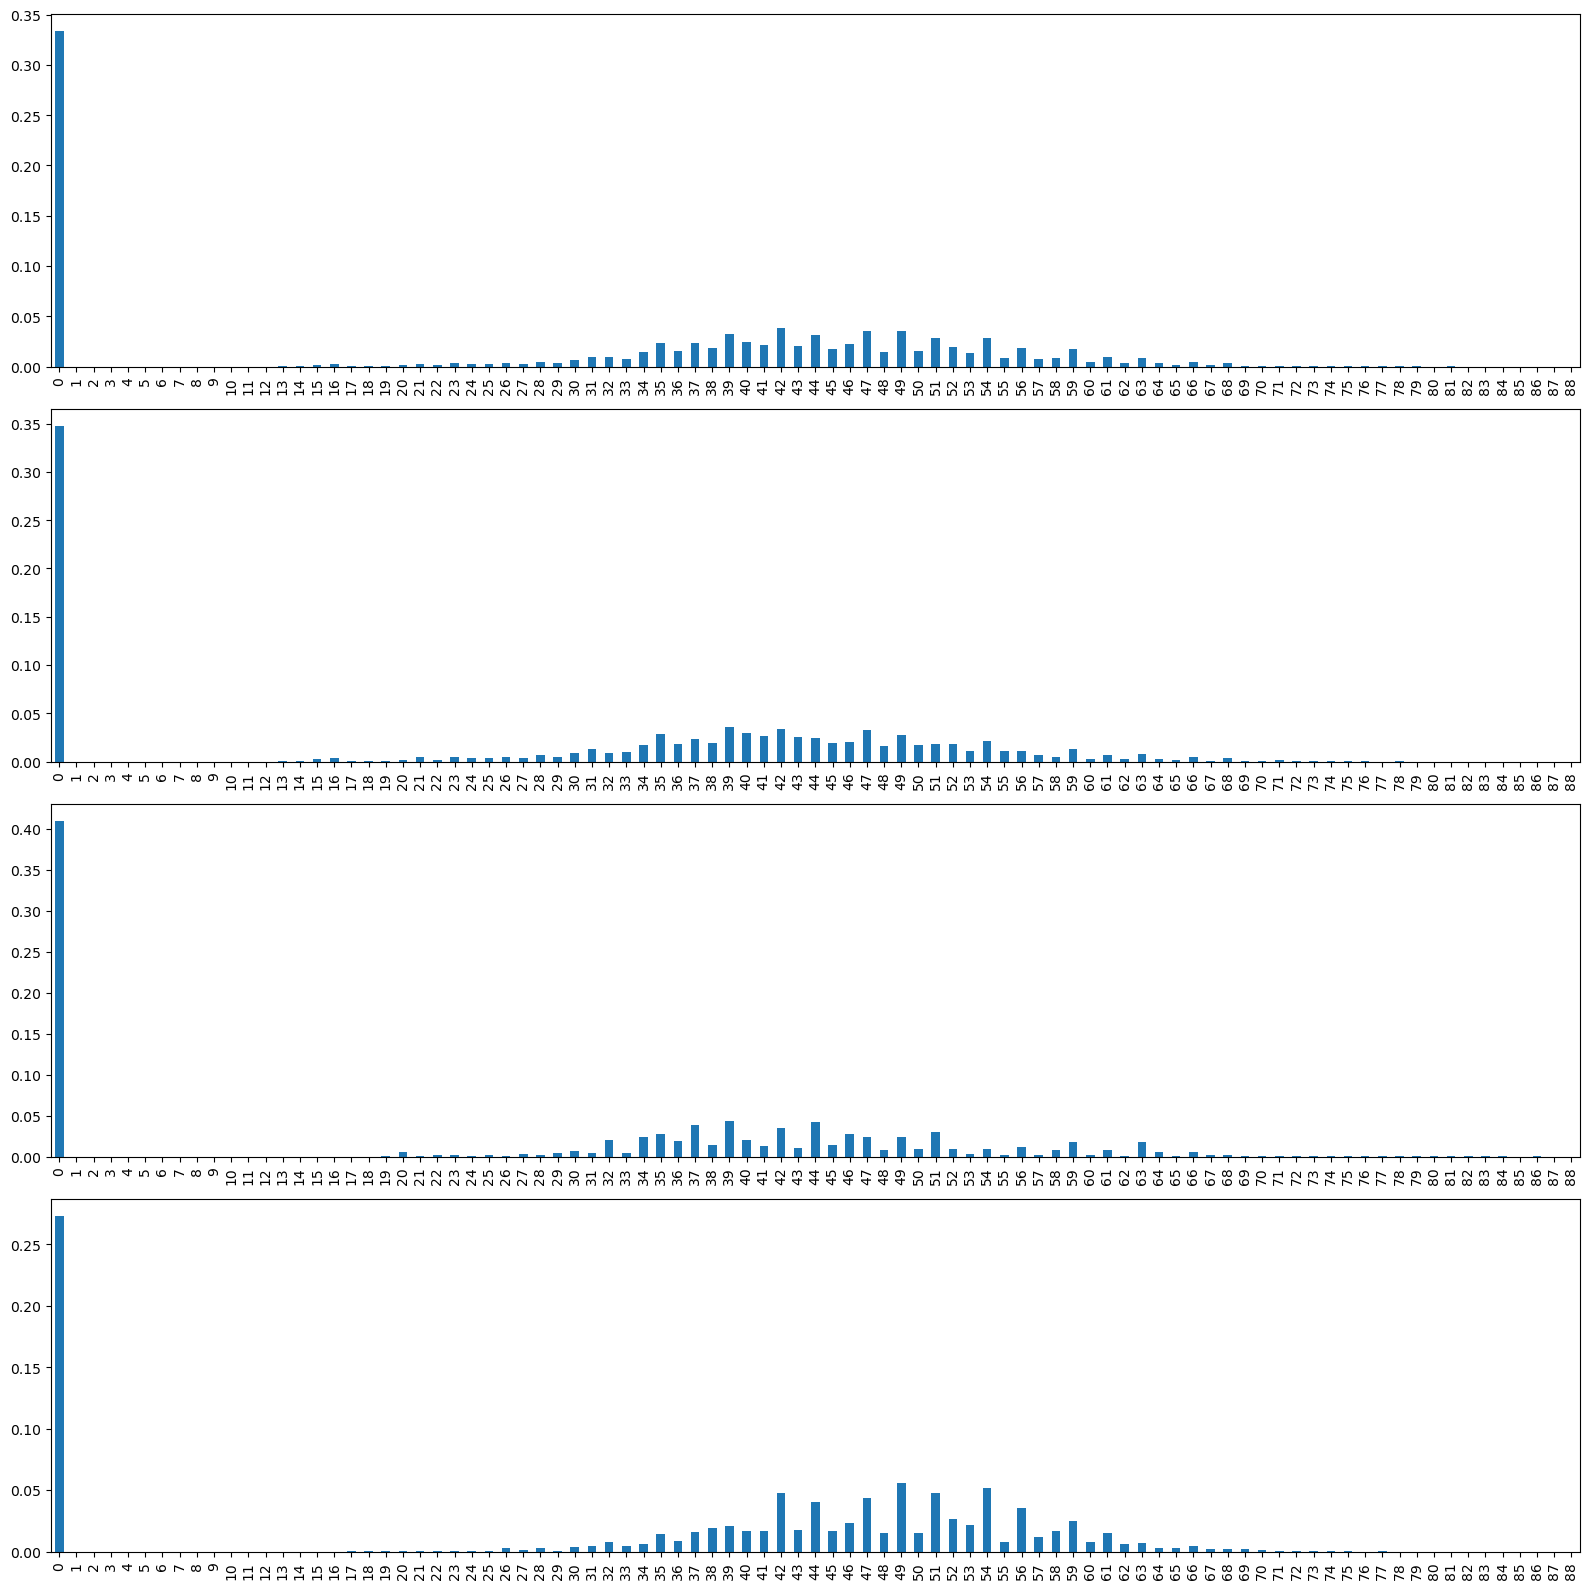

In [28]:
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(16,16)) 
series[0].plot(kind='bar', ax=ax0)
series[1].plot(kind='bar', ax=ax1)
series[2].plot(kind='bar', ax=ax2)
series[3].plot(kind='bar', ax=ax3)
fig.tight_layout()
plt.plot()

In [3]:
import librosa
import mir_eval
import numpy as np

from pitch_tracker.utils.constants import F_MIN, MIDI_END
F_MAX = librosa.midi_to_hz(MIDI_END)
def rand_one_hot_encode(n, m):
    """
    Generate a one-hot encoded matrix with n samples and m classes using PyTorch.
    :param n: int, number of samples
    :param m: int, number of classes
    :return: torch tensor of shape (n, m)
    """
    one_hot = torch.zeros(n, m)
    for i in range(n):
        one_hot[i][torch.randint(0, m, (1,))] = 1
    return one_hot

def class_to_frequency(class_inputs:np.ndarray, minF0=F_MIN, maxF0=F_MAX, number_of_classes=89, step_notes=1):
    '''
    Converts class labels to frequency in Hz
    :param input_class: A list of classes
    :param minF0: Minimum frequency
    :param maxF0: Maximum frequency
    :param number_of_classes: Number of classes
    :param step_notes: Number of F0s in one semitone
    :return: output_freq: Output frequencies for class symbols
    '''
    # pitches = 
    output_freq = np.zeros(class_inputs.shape)

    F0_list = minF0 * 2 ** (np.arange(number_of_classes - 1) / (12. * step_notes))
    F0_list = np.append(0, F0_list)
    print(F0_list)

    output_freq = F0_list[class_inputs]

    return output_freq

In [25]:
np.arange(89 - 1) 

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87])

In [4]:
y_true = rand_one_hot_encode(5, 89)
y_pred = rand_one_hot_encode(5, 89)

In [30]:
pitch_true = torch.argmax(y_true, dim=1)
pitch_pred = torch.argmax(y_pred, dim=1)

voiced_frame_true = y_true[:,0] == 0
voiced_frame_pred = y_pred[:,0] == 0

In [31]:
pitch_true.numpy()

array([65, 87, 37, 62, 36])